Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [8]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [9]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [10]:
# split train into train and val 
from sklearn.model_selection import train_test_split
train , val = train_test_split(train, test_size=len(test), 
                               stratify = train['status_group'], random_state = 42)

In [11]:
import numpy as np 

def wrangle(X):

  #prevent SettingWithCopy warning
  X = X.copy()

  #replace really small nums in latitude with zeros
  X['latitude'] = X['latitude'].replace(-2.000000e-08, 0)

  #for both cols replace zeros with nans:
  cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'public_meeting', ]
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  X['date_recorded'] = pd.to_datetime(X['date_recorded'])
  X['day_recorded'] = pd.DatetimeIndex(X['date_recorded']).day
  X['month_recorded'] = pd.DatetimeIndex(X['date_recorded']).month
  X['year_recorded'] = pd.DatetimeIndex(X['date_recorded']).year
  X['years_since_construction'] = X['year_recorded'] - X['construction_year']

  # Reduce cardinality for funder feature ...
  top49 = train['funder'].value_counts()[:49].index
  X.loc[~X['funder'].isin(top49), 'funder'] = 'other'

  #enough water?
  X['enough'] = np.where(X['quantity'] == 'enough', 1, 0)


  #peple per water
  X['pop_per_water'] = X['amount_tsh'] / X['population']

  #drop one of the same/almost same cols, cols with a lot of missing data
  X = X.drop(columns= ['quantity_group', 'date_recorded', 'payment_type', 'num_private',  
                       'source_class', 'source_type', 'waterpoint_type_group', 'quality_group',
                       'extraction_type_group', 'extraction_type_class', 'management_group', 'scheme_management'])
  
  #replace infinity nyms with nul vals
  X = X.replace([np.inf, -np.inf], np.nan)

  #return wrangled dataset
  return X

In [12]:
#wrangle train test and val the same way
test = wrangle(test)
train = wrangle(train)
val = wrangle(val)

In [13]:
#select features
target = 'status_group'

#get a data frame with all features
train_features = train.drop(columns = [target, 'id', 'recorded_by'])

#get numeric features
numeric = train_features.select_dtypes(include='number').columns.tolist()

#get cardinality of categorical colummns
cardinality = train_features.select_dtypes(exclude = 'number').nunique()

#exlude columns with cardinality more than 50 
categorical = cardinality[cardinality <= 50 ].index.tolist()

#combine
features = categorical + numeric

print(features)

['funder', 'basin', 'region', 'public_meeting', 'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'day_recorded', 'month_recorded', 'year_recorded', 'years_since_construction', 'enough', 'pop_per_water']


In [14]:
#devide into features and target 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [18]:
y_val 

58046             non functional
41184             non functional
27587                 functional
53109                 functional
7245     functional needs repair
                  ...           
18760                 functional
36059             non functional
4759                  functional
43621                 functional
45295                 functional
Name: status_group, Length: 14358, dtype: object

In [19]:
y_pred

array(['non functional', 'non functional', 'functional', ...,
       'functional', 'functional', 'functional'], dtype=object)

In [24]:
# imports
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score

#make and fit pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    #StandardScaler(),
    #SelectKBest(f_regression, k = 40),
    RandomForestClassifier(min_samples_leaf=10, max_depth = 30, random_state=42, n_jobs=-1)
)

#get scores 
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7994149603008776


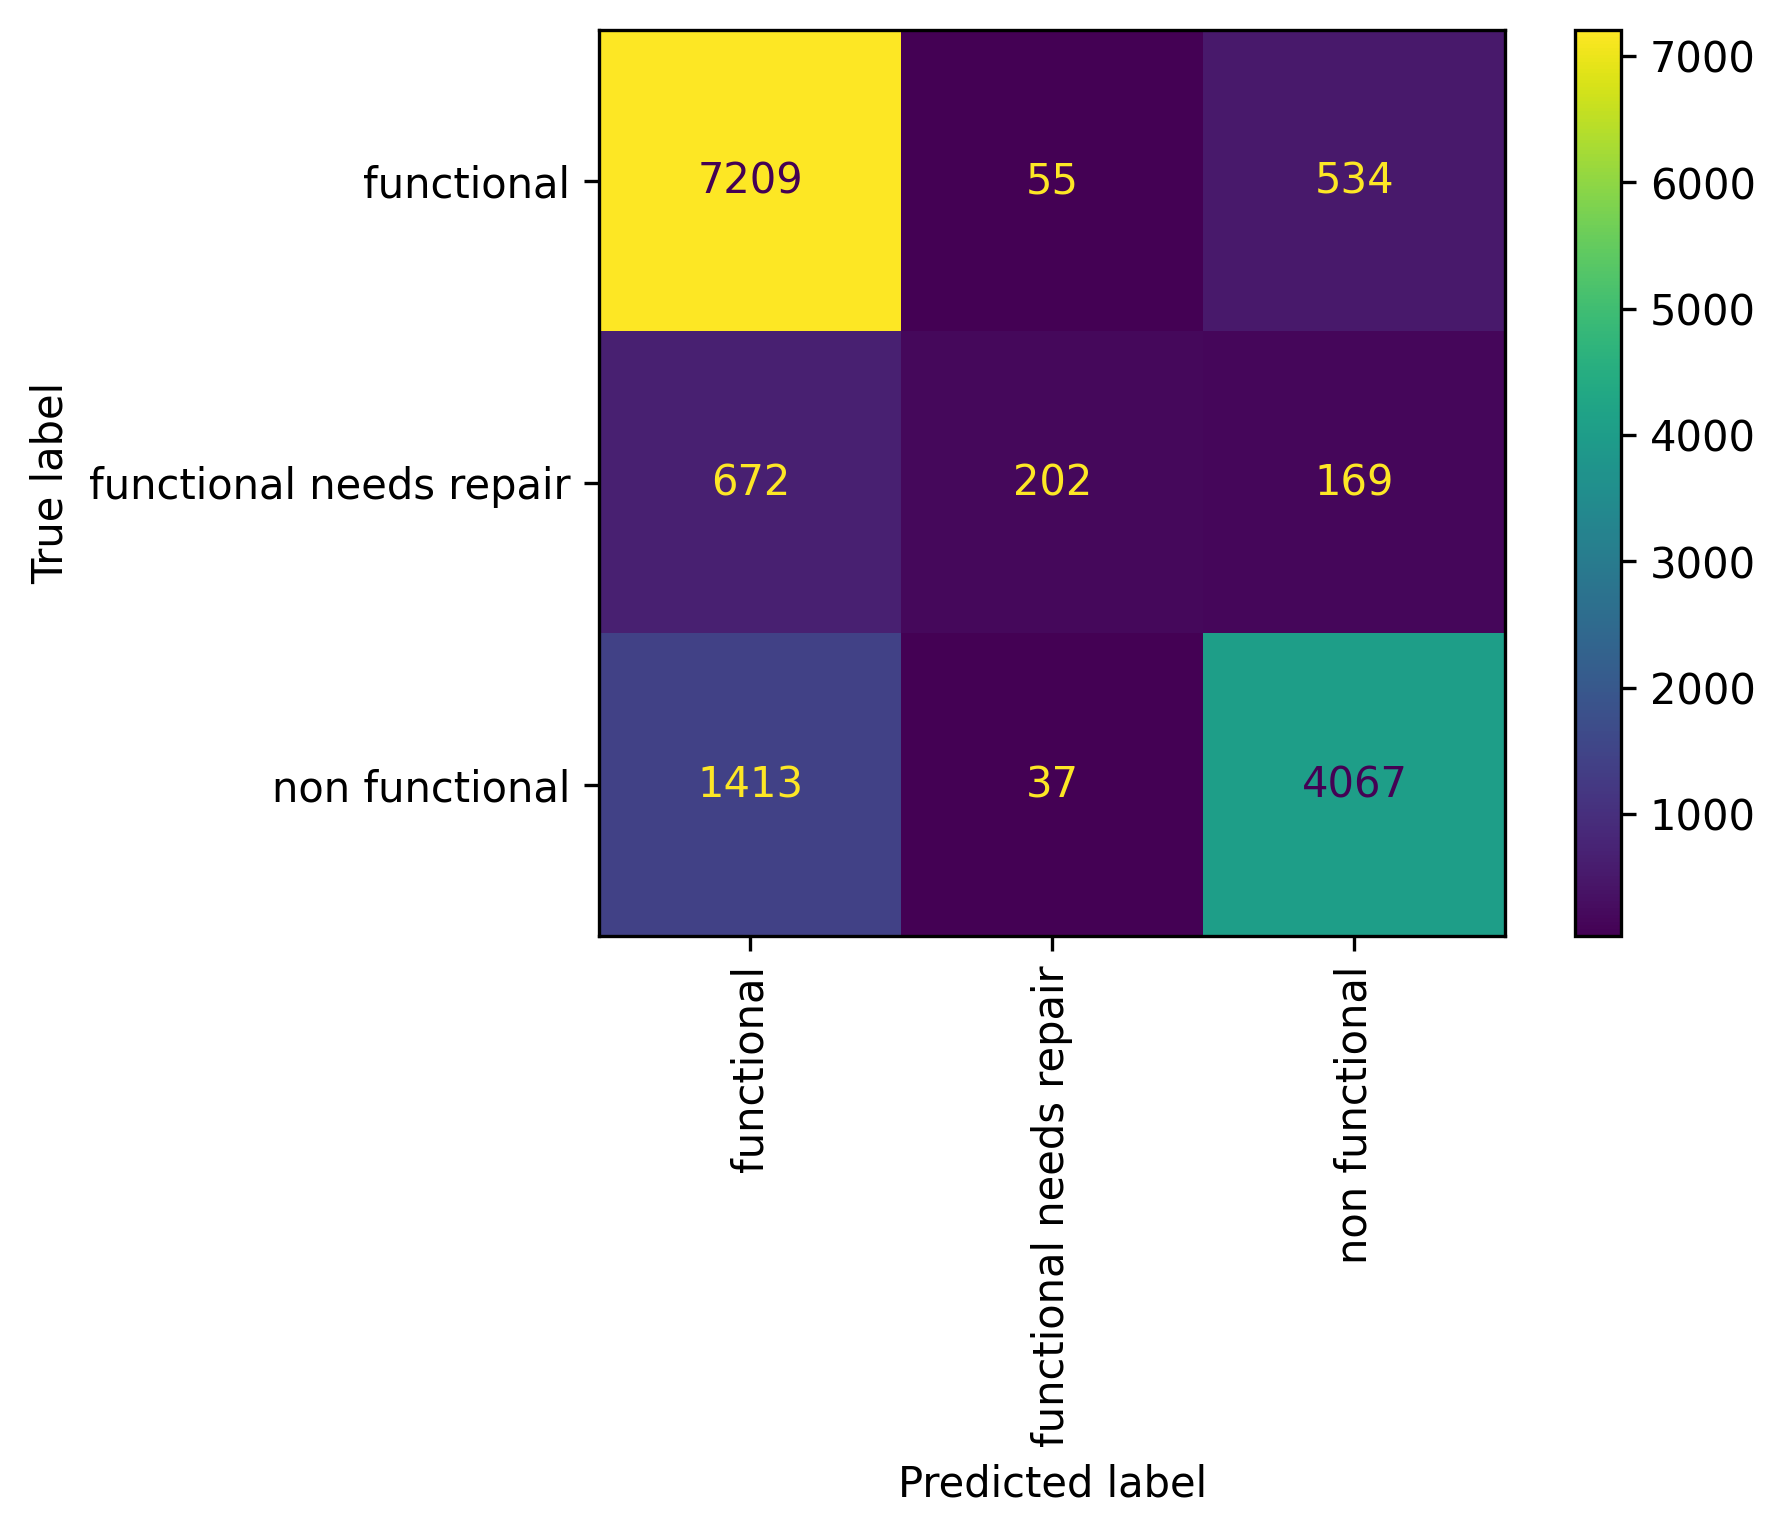

In [27]:
#plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [28]:
correct_predictions = 7209 + 202 + 4067
correct_predictions

11478

In [30]:
total_predictions = correct_predictions + 672 + 1413 + 37 + 55 + 534 + 169
total_predictions

14358

In [36]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.92      0.84      7798
functional needs repair       0.69      0.19      0.30      1043
         non functional       0.85      0.74      0.79      5517

               accuracy                           0.80     14358
              macro avg       0.77      0.62      0.65     14358
           weighted avg       0.80      0.80      0.78     14358



In [38]:
y_train = y_train!= 'functional'
y_val = y_val != 'functional'

In [39]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

In [41]:
pipeline.predict_proba(X_val)

array([[0.00605554, 0.99394446],
       [0.25529835, 0.74470165],
       [0.98579401, 0.01420599],
       ...,
       [0.79101067, 0.20898933],
       [0.420869  , 0.579131  ],
       [0.93018426, 0.06981574]])

In [46]:
threshold = 0.80
sum(pipeline.predict_proba(X_val)[:,1] >= threshold)

3006